In [1]:
import tensorflow as tf
import numpy as np
from censai.data.cosmos import decode_image, decode_shape, preprocess_image
from censai.utils import nullwriter
from censai.definitions import PolynomialSchedule
from censai.models import VAE, VAESecondStage
import os, glob, json
import math
import matplotlib.pyplot as plt
from datetime import datetime
import time

VAE_HPARAMS = [
    "hidden_layers",
    "kernel_reg_amp",
    "bias_reg_amp",
    "activation",
    "latent_size",
    "units",
    "output_size"
]

In [2]:
def main(args):
    files = []
    for dataset in args.datasets:
        files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
    np.random.shuffle(files)
    # Read concurrently from multiple records
    files = tf.data.Dataset.from_tensor_slices(files)
    dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=args.compression_type),
                               block_length=args.block_length, num_parallel_calls=tf.data.AUTOTUNE)
    # Read off global parameters from first example in dataset
    for pixels in dataset.map(decode_shape):
        break
    vars(args).update({"pixels": int(pixels)})
    dataset = dataset.map(decode_image).map(preprocess_image).batch(args.batch_size)
    if args.cache_file is not None:
        dataset = dataset.cache(args.cache_file).prefetch(tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    train_dataset = dataset.take(math.floor(args.train_split * args.total_items / args.batch_size)) # dont forget to divide by batch size!
    val_dataset = dataset.skip(math.floor(args.train_split * args.total_items / args.batch_size))
    val_dataset = val_dataset.take(math.ceil((1 - args.train_split) * args.total_items / args.batch_size))

    # Load fisrt stage and freeze weights
    with open(os.path.join(args.first_stage_model, "model_hparams.json"), "r") as f:
        vae_hparams = json.load(f)
    vae = VAE(**vae_hparams)
    ckpt1 = tf.train.Checkpoint(step=tf.Variable(1), net=vae)
    checkpoint_manager1 = tf.train.CheckpointManager(ckpt1, args.first_stage_model, 1)
    checkpoint_manager1.checkpoint.restore(checkpoint_manager1.latest_checkpoint).expect_partial()
    vae.trainable = False
    vae.encoder.trainable = False
    vae.decoder.trainable = False

    vars(args).update({"output_size": vae_hparams["latent_size"]})

    # Create second stage
    vae2 = VAESecondStage(
        latent_size=args.latent_size,
        output_size=args.output_size,
        units=args.units,
        hidden_layers=args.hidden_layers,
        activation=args.activation,
        kernel_reg_amp=args.kernel_reg_amp,
        bias_reg_amp=args.bias_reg_amp
    )

    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=args.initial_learning_rate,
        decay_rate=args.decay_rate,
        decay_steps=args.decay_steps,
        staircase=args.staircase
    )
    beta_schedule = PolynomialSchedule(initial_value=args.beta_init, end_value=args.beta_end_value, power=args.beta_decay_power, decay_steps=args.beta_decay_steps, cyclical=args.beta_cyclical)
    optim = tf.keras.optimizers.deserialize(
        {
            "class_name": args.optimizer,
            'config': {"learning_rate": learning_rate_schedule}
        }
    )
    first_stage_name = os.path.split(args.first_stage_model)[-1]
    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        logname = args.model_id
    elif args.logname is not None:
        logname = first_stage_name + "_second_stage_" + args.logname
    else:
        logname = first_stage_name + "_second_stage_" + datetime.now().strftime("%y%m%d%H%M%S")
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        writer = tf.summary.create_file_writer(logdir)
    else:
        writer = nullwriter()
    print(logname)
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        checkpoints_dir = os.path.join(args.model_dir, logname)
        if not os.path.isdir(checkpoints_dir):
            os.mkdir(checkpoints_dir)
            with open(os.path.join(checkpoints_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f, indent=4)
            with open(os.path.join(checkpoints_dir, "model_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in VAE_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
        ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=vae2)
        checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            if args.load_checkpoint == "lastest":
                checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint)
            elif args.load_checkpoint == "best":
                scores = np.loadtxt(os.path.join(checkpoints_dir, "score_sheet.txt"))
                _checkpoint = scores[np.argmin(scores[:, 1]), 0]
                checkpoint = checkpoint_manager.checkpoints[_checkpoint]
                checkpoint_manager.checkpoint.restore(checkpoint)
            else:
                checkpoint = checkpoint_manager.checkpoints[int(args.load_checkpoint)]
                checkpoint_manager.checkpoint.restore(checkpoint)
    else:
        save_checkpoint = False

    def train_step(x, step):
        with tf.GradientTape() as tape:
            tape.watch(vae2.trainable_weights)
            reconstruction_loss, kl_loss = vae2.cost_function(x)
            cost = tf.reduce_sum(reconstruction_loss + beta_schedule(step) * kl_loss) / args.batch_size
        gradients = tape.gradient(cost, vae2.trainable_weights)
        if args.clipping:
            gradients = [tf.clip_by_value(grad, -10, 10) for grad in gradients]
        optim.apply_gradients(zip(gradients, vae2.trainable_weights))
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        kl_loss = tf.reduce_mean(kl_loss)
        return cost, reconstruction_loss, kl_loss

    def test_step(x,  step):
        reconstruction_loss, kl_loss = vae2.cost_function(x)
        cost = tf.reduce_sum(reconstruction_loss + beta_schedule(step) * kl_loss) / args.batch_size
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        kl_loss = tf.reduce_mean(kl_loss)
        return cost, reconstruction_loss, kl_loss

    # ====== Training loop ============================================================================================
    epoch_loss = tf.metrics.Mean()
    epoch_reconstruction_loss = tf.metrics.Mean()
    epoch_kl_loss = tf.metrics.Mean()
    time_per_step = tf.metrics.Mean()
    val_loss = tf.metrics.Mean()
    val_reconstruction_loss = tf.metrics.Mean()
    val_kl_loss = tf.metrics.Mean()
    history = {  # recorded at the end of an epoch only
        "train_cost": [],
        "val_cost": [],
        "learning_rate": [],
        "time_per_step": [],
        "train_reconstruction_loss": [],
        "val_reconstruction_loss": [],
        "train_kl_loss": [],
        "val_kl_loss": []
    }
    best_loss = np.inf
    patience = args.patience
    step = 0
    global_start = time.time()
    estimated_time_for_epoch = 0
    out_of_time = False
    lastest_checkpoint = 1
    for epoch in range(args.epochs):
        if (time.time() - global_start) > args.max_time * 3600 - estimated_time_for_epoch:
            break
        epoch_start = time.time()
        epoch_loss.reset_states()
        epoch_reconstruction_loss.reset_states()
        epoch_kl_loss.reset_states()
        time_per_step.reset_states()
        with writer.as_default():
            for batch, x in enumerate(train_dataset):
                x, _, _ = vae.encode(x)  # Get latent code
                start = time.time()
                cost, reconstruction_loss, kl_loss = train_step(x, step=step)  # train on latent code
                # ========== Summary and logs ====================================================================
                _time = time.time() - start
                tf.summary.scalar("beta", beta_schedule(step), step=step)
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
                epoch_reconstruction_loss.update_state([reconstruction_loss])
                epoch_kl_loss.update_state([kl_loss])
                step += 1
            # ========== Validation set ===================
            val_loss.reset_states()
            val_reconstruction_loss.reset_states()
            val_kl_loss.reset_states()
            for x in val_dataset:
                x, _, _ = vae.encode(x)
                cost, reconstruction_loss, kl_loss = test_step(x, step=step)
                val_loss.update_state([cost])
                val_reconstruction_loss.update_state([reconstruction_loss])
                val_kl_loss.update_state([kl_loss])

            val_cost = val_loss.result().numpy()
            train_cost = epoch_loss.result().numpy()
            train_reconstruction_cost = epoch_reconstruction_loss.result().numpy()
            val_reconstruction_cost = val_reconstruction_loss.result().numpy()
            train_kl_cost = epoch_kl_loss.result().numpy()
            val_kl_cost = val_kl_loss.result().numpy()
            tf.summary.scalar("KL", train_kl_cost, step=step)
            tf.summary.scalar("Val KL", val_kl_cost, step=step)
            tf.summary.scalar("Reconstruction loss", train_reconstruction_cost, step=step)
            tf.summary.scalar("Val reconstruction loss", val_reconstruction_cost, step=step)
            tf.summary.scalar("MSE", train_cost, step=step)
            tf.summary.scalar("Val MSE", val_cost, step=step)
            tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
        print(f"epoch {epoch} | train loss {train_cost:.3e} | val loss {val_cost:.3e} "
              f"| learning rate {optim.lr(step).numpy():.2e} | kl divergence {train_kl_cost:.2e} | reconstruction cost {train_reconstruction_cost:.2e} " 
              f"| beta {beta_schedule(step):.2f}")
        history["train_cost"].append(train_cost)
        history["val_cost"].append(val_cost)
        history["train_reconstruction_loss"].append(train_reconstruction_cost)
        history["val_reconstruction_loss"].append(val_reconstruction_cost)
        history["train_kl_loss"].append(train_kl_cost)
        history["val_kl_loss"].append(val_kl_cost)
        history["learning_rate"].append(optim.lr(step).numpy())
        history["time_per_step"].append(time_per_step.result().numpy())

        cost = train_cost if args.track_train else val_cost
        if np.isnan(cost):
            print("Training broke the Universe")
            break
        if cost < (1 - args.tolerance) * best_loss:
            best_loss = cost
            patience = args.patience
        else:
            patience -= 1
        if (time.time() - global_start) > args.max_time * 3600:
            out_of_time = True
        if save_checkpoint:
            checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1 or out_of_time:
                with open(os.path.join(checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                lastest_checkpoint += 1
                checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(checkpoint_manager.checkpoint.step), checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break
        if out_of_time:
            break
        if epoch > 0:  # First epoch is always very slow and not a good estimate of an epoch time.
            estimated_time_for_epoch = time.time() - epoch_start
    print(f"Finished training after {(time.time() - global_start)/3600:.3f} hours.")
    return history, vae, vae2, train_dataset, val_dataset

In [3]:
from argparse import ArgumentParser
parser = ArgumentParser()
parser.add_argument("--first_stage_model",      required=True,                  help="Path to first stage VAE checkpoint directory.")
parser.add_argument("--model_id",               default="None",                 help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--load_checkpoint",        default="best",                 help="One of 'best', 'lastest' or the specific checkpoint index.")
parser.add_argument("--datasets",               required=True, nargs="+",       help="Path to kappa directories, with tfrecords files")
parser.add_argument("--compression_type",       default=None,                   help="Compression type used to write data. Default assumes no compression.")

# Model params
parser.add_argument("--hidden_layers",                 default=4,              type=int,       help="Number of layer in encoder/decoder")
parser.add_argument("--kernel_reg_amp",         default=1e-4,           type=float,     help="L2 kernel regularization amplitude")
parser.add_argument("--bias_reg_amp",           default=1e-4,           type=float,     help="L2 bias regularizer amplitude")
parser.add_argument("--activation",             default="relu",                         help="Name of activation function, on of ['relu', 'leaky_relu', 'bipolar_relu', 'bipolar_leaky_relu', 'bipolar_elu', 'gelu', etc.]")
parser.add_argument("--latent_size",            default=16,             type=int,       help="Twice the size of the latent code vector z")
parser.add_argument("--units",                  default=32,             type=int,       help="Number of hidden unit in MLP layers")

# Training set params
parser.add_argument("-b", "--batch_size",       default=1,      type=int,       help="Number of images in a batch. ")
parser.add_argument("--train_split",            default=0.8,    type=float,     help="Fraction of the training set.")
parser.add_argument("--total_items",            required=True,  type=int,       help="Total images in an epoch.")
# ... for tfrecord dataset
parser.add_argument("--cache_file",             default=None,                   help="Path to cache file, useful when training on server. Use ${SLURM_TMPDIR}/cache")
parser.add_argument("--block_length",           default=1,      type=int,       help="Number of example to read from each files at a given batch.")

# Optimization params
parser.add_argument("-e", "--epochs",                   default=10,     type=int,       help="Number of epochs for training.")
parser.add_argument("--optimizer",                      default="Adam",                 help="Class name of the optimizer (e.g. 'Adam' or 'Adamax')")
parser.add_argument("--initial_learning_rate",          default=1e-3,   type=float,     help="Initial learning rate.")
parser.add_argument("--decay_rate",                     default=1.,     type=float,     help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",                    default=1000,   type=int,       help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--beta_init",                      default=0.,     type=float,     help="Initial value of the beta schedule")
parser.add_argument("--beta_end_value",                 default=1.,     type=float,     help="End value of the beta schedule")
parser.add_argument("--beta_decay_power",               default=1.,     type=float,     help="Power of the Polynomial schedule")
parser.add_argument("--beta_decay_steps",               default=1000,   type=int,       help="Number of steps until end of schedule is reached")
parser.add_argument("--beta_cyclical",                  default=0,      type=int,       help="Make beta schedule cyclical if 1. 0: Monotone schedule.")
parser.add_argument("--staircase",                      action="store_true",            help="Learning rate schedule only change after decay steps if enabled.")
parser.add_argument("--clipping",                       action="store_true",            help="Clip backprop gradients between -10 and 10.")
parser.add_argument("--patience",                       default=np.inf, type=int,       help="Number of step at which training is stopped if no improvement is recorder.")
parser.add_argument("--tolerance",                      default=0,      type=float,     help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")
parser.add_argument("--track_train",                    action="store_true",            help="Track training metric instead of validation metric, in case we want to overfit")
parser.add_argument("--max_time",                       default=np.inf, type=float,     help="Time allowed for the training, in hours.")

# logs
parser.add_argument("--logdir",                  default="None",                help="Path of logs directory. Default if None, no logs recorded.")
parser.add_argument("--logname",                 default=None,                  help="Overwrite name of the log with this argument")
parser.add_argument("--model_dir",               default="None",                help="Path to the directory where to save models checkpoints.")
parser.add_argument("--checkpoints",             default=10,    type=int,       help="Save a checkpoint of the models each {%} iteration.")
parser.add_argument("--max_to_keep",             default=3,     type=int,       help="Max model checkpoint to keep.")

# Reproducibility params
parser.add_argument("--seed",                   default=None,   type=int,       help="Random seed for numpy and tensorflow.")
parser.add_argument("--json_override",          default=None,   nargs="+",      help="A json filepath that will override every command line parameters. Useful for reproducibility")



_StoreAction(option_strings=['--json_override'], dest='json_override', nargs='+', const=None, default=None, type=None, choices=None, help='A json filepath that will override every command line parameters. Useful for reproducibility', metavar=None)

In [14]:
import sys
sys.argv = ['']
args = parser.parse_args(
  f"--first_stage_model={os.getenv('CENSAI_PATH')}/models/VAE1_cosmos_HPARAMS_029_L3_CL4_F16_NLleaky_relu_LS128_ssi0.001_210810161842 "\
  f"--datasets {os.getenv('CENSAI_PATH')}/data/cosmos_23.5_preprocessed_highSNR/ "\
#   f"--compression_type=GZIP "\
  f"--epochs=20 "\
  f"--optimizer=Adam "\
  f"--initial_learning_rate 1e-3 "\
  f"--decay_rate=0.5 "\
  f"--decay_steps=20000 "\
  f"--beta_init=0. "\
  f"--beta_end_value=0.05 "\
  f"--beta_decay_power=1 "\
  f"--beta_decay_steps=15000 "\
  f"--beta_cyclical=0 "\
  f"--staircase "\
  f"--clipping "\
  f"--patience=4 "\
  f"--tolerance=0.0 "\
  f"--batch_size=40 "\
  f"--train_split=0.9 "\
  f"--total_items=40000 "\
  f"--block_length=1 "\
  f"--hidden_layers=1 "\
  f"--kernel_reg_amp=1e-3 "\
  f"--bias_reg_amp=1e-3 "\
  f"--activation=leaky_relu "\
  f"--latent_size=64 "\
  f"--units=128 "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
  f"--logdir={os.getenv('CENSAI_PATH')}/logsVAE_cosmos "\
  f"--model_dir={os.getenv('CENSAI_PATH')}/models "\
  f"--checkpoints=5 "\
  f"--max_to_keep=10".split()
)

cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
if args.seed is not None:
    tf.random.set_seed(args.seed)
    np.random.seed(args.seed)

history, vae, vae2, train_dataset, val_dataset = main(args)

VAE1_cosmos_HPARAMS_029_L3_CL4_F16_NLleaky_relu_LS128_ssi0.001_210810161842_second_stage_210812235647
epoch 0 | train loss 8.433e+01 | val loss 6.913e+01 | learning rate 1.00e-03 | kl divergence 1.58e+02 | reconstruction cost 8.40e+01 | beta 0.00
Saved checkpoint for step 2: /home/aadam/scratch/Censai//models/VAE1_cosmos_HPARAMS_029_L3_CL4_F16_NLleaky_relu_LS128_ssi0.001_210810161842_second_stage_210812235647/ckpt-1
epoch 1 | train loss 6.793e+01 | val loss 6.744e+01 | learning rate 1.00e-03 | kl divergence 2.34e+02 | reconstruction cost 6.69e+01 | beta 0.01
epoch 2 | train loss 6.691e+01 | val loss 6.616e+01 | learning rate 1.00e-03 | kl divergence 2.03e+02 | reconstruction cost 6.54e+01 | beta 0.01
epoch 3 | train loss 6.621e+01 | val loss 6.618e+01 | learning rate 1.00e-03 | kl divergence 1.82e+02 | reconstruction cost 6.43e+01 | beta 0.01
epoch 4 | train loss 6.609e+01 | val loss 6.637e+01 | learning rate 1.00e-03 | kl divergence 1.71e+02 | reconstruction cost 6.38e+01 | beta 0.02


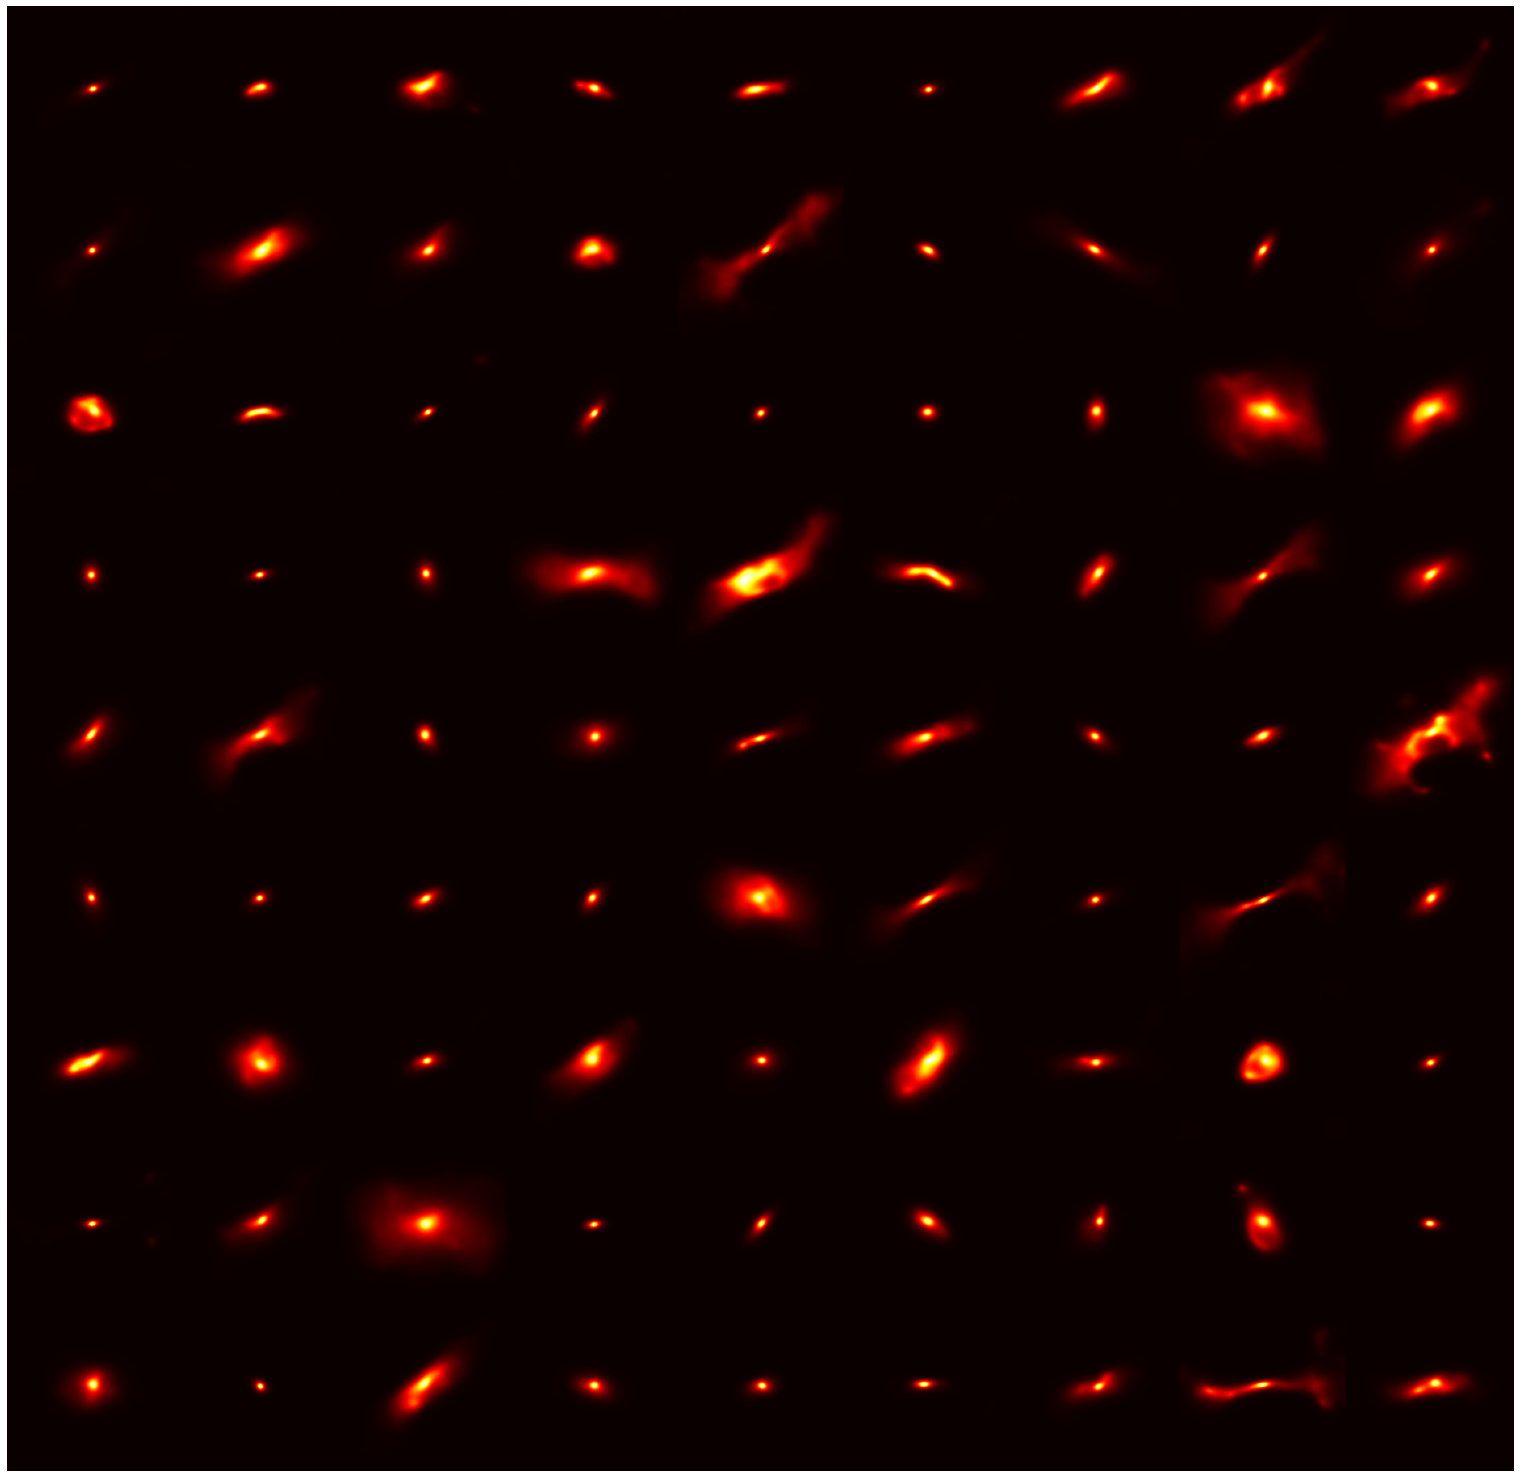

In [15]:
z = vae2.sample(81)
y = vae.decode(z)
fig, axs = plt.subplots(9, 9, figsize=(27, 27))
for i in range(9):
    for j in range(9):
        k = 9 * j + i 
        axs[i, j].imshow(y[k, ..., 0], cmap="hot", origin="lower")
        axs[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=-0.05)

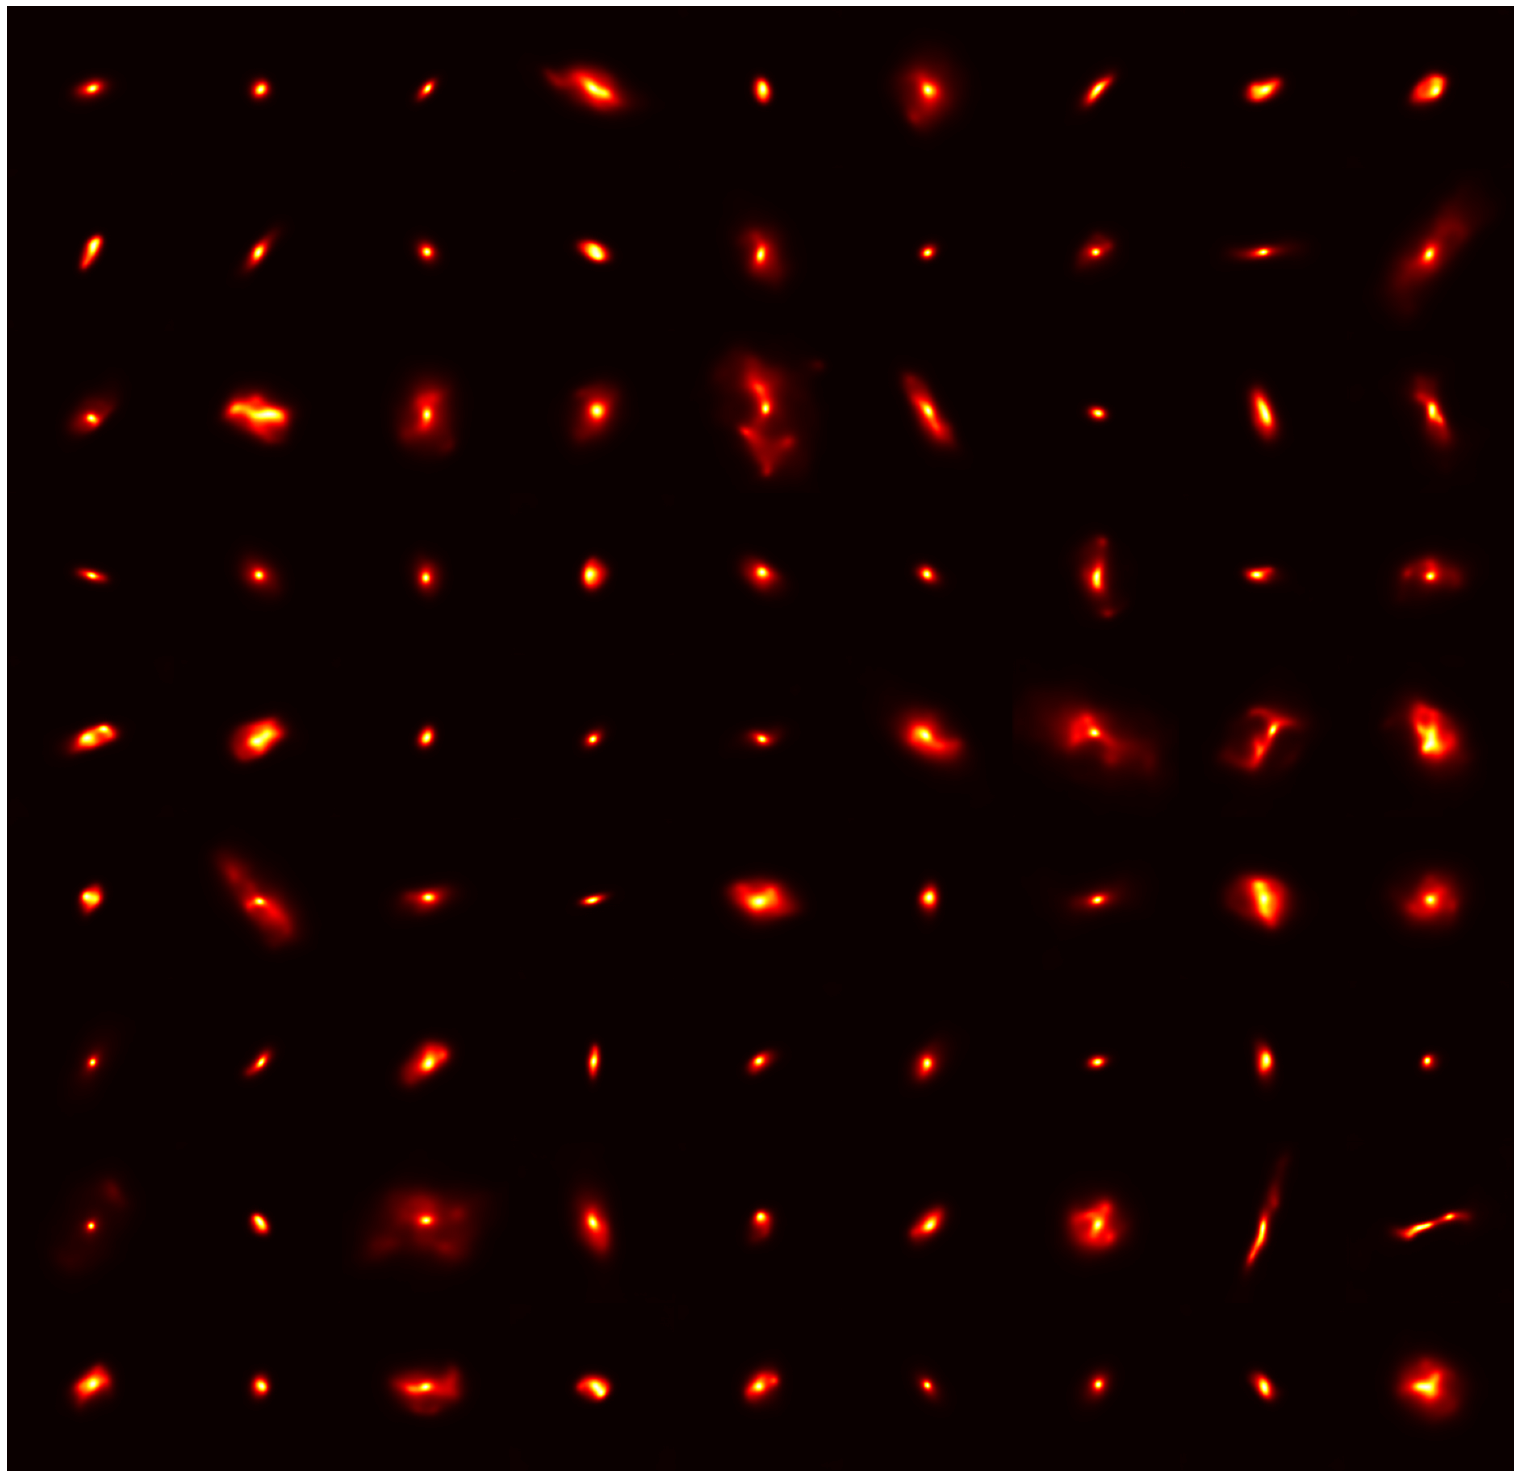

In [16]:
y = vae.sample(81)
fig, axs = plt.subplots(9, 9, figsize=(27, 27))
for i in range(9):
    for j in range(9):
        k = 9 * j + i 
        axs[i, j].imshow(y[k, ..., 0], cmap="hot", origin="lower")
        axs[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=-0.05)